## **DATA LOADING**

# Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
from glob import glob
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# Reading the data

In [ ]:
import pandas as pd
df = pd.read_csv('state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

# Dividing Training and Validation data

In [ ]:
import splitfolders
data_dir = 'state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(data_dir, output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [00:02, 9861.12 files/s] 


In [ ]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Keras version is the same as TensorFlow version.")



TensorFlow version: 2.16.1
Keras version is the same as TensorFlow version.


# Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator




# Set the batch size and image size for the data generator
batch_size = 32
img_height = 224
img_width = 224

# Create an instance of the ImageDataGenerator class with no augmentation
datagen_train = ImageDataGenerator(rescale=1./255)

# Create a separate instance of the ImageDataGenerator class for the validation data
datagen_val = ImageDataGenerator(rescale=1./255)

# Create separate generators for the training and validation sets
train_generator = datagen_train.flow_from_directory(
    'output/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_val.flow_from_directory(
    'output/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',

)

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


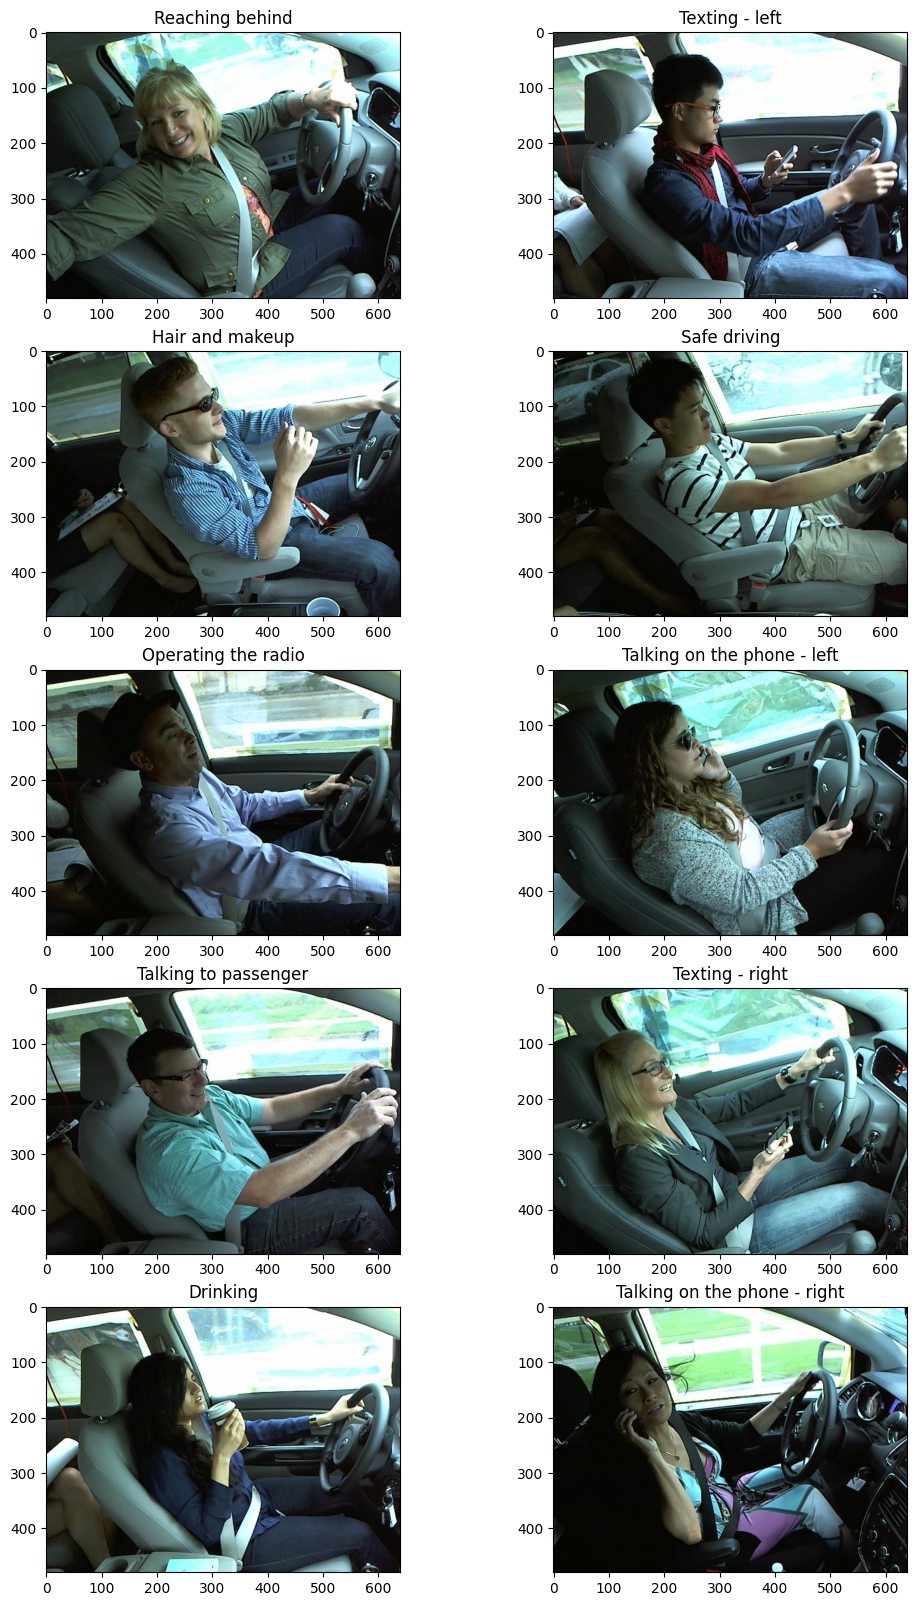

In [ ]:
import matplotlib.pyplot as plt
import os
labels = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(labels[directory])

## **MODELS CREATION and TRAINING**

# Model with 500,000 parameters

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

model5 = Sequential([
    # Increase the number of filters
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    # Adding more filters to the subsequent layers
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Use a larger convolution layer before global pooling
    Conv2D(256, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),

    # Increasing the dense layer size
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(10, activation='softmax')
])



In [ ]:
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model5.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 53, 53, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,130 (2.00 MB)

 Trainable params: 525,130 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [ ]:

history5 = model5.fit(
    train_generator,

    validation_data=val_generator,
    batch_size = 32,
    epochs=10
)


Epoch 1/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 136s 240ms/step - accuracy: 0.1328 - loss: 2.2281 - val_accuracy: 0.4321 - val_loss: 1.3451
Epoch 2/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 138s 244ms/step - accuracy: 0.5291 - loss: 1.1722 - val_accuracy: 0.8278 - val_loss: 0.5445
Epoch 3/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 152s 262ms/step - accuracy: 0.8482 - loss: 0.4779 - val_accuracy: 0.9218 - val_loss: 0.2544
Epoch 4/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 192s 244ms/step - accuracy: 0.9395 - loss: 0.2073 - val_accuracy: 0.9731 - val_loss: 0.1002
Epoch 5/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 144s 256ms/step - accuracy: 0.9675 - loss: 0.1124 - val_accuracy: 0.9673 - val_loss: 0.1016
Epoch 6/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 191s 237ms/step - accuracy: 0.9784 - loss: 0.0775 - val_accuracy: 0.9708 - val_loss: 0.0902
Epoch 7/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 149s 265ms/step - accuracy: 0.9834 - loss: 0.0561 - val_accuracy: 0.9829 - val_loss: 0.0596
Epoch 8/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 131s 232ms/step - accuracy: 0.9875 -

In [ ]:
model5.save('model5with500k.h5')

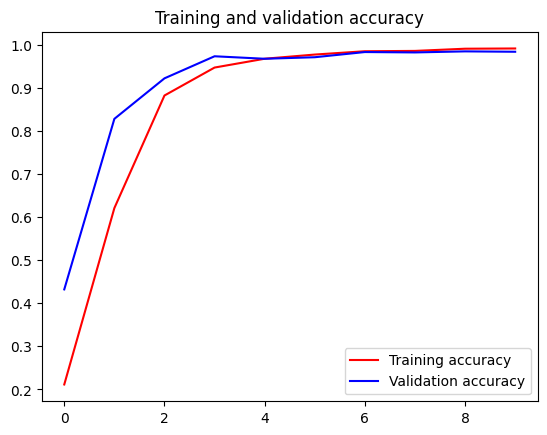

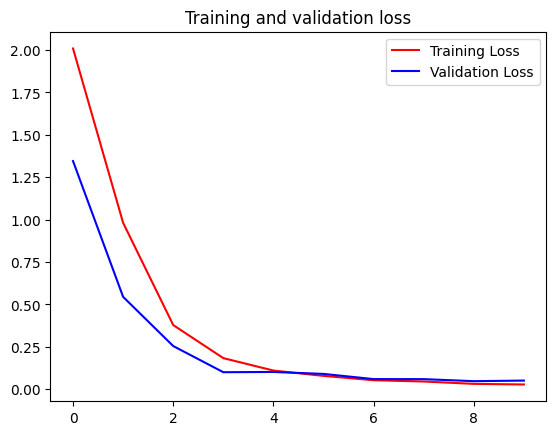

In [ ]:
import matplotlib.pyplot as plt

acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Model with 500k parameters with dropout and batch normalisation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization

model6 = Sequential([
    # Increase the number of filters
    Conv2D(32, (3, 3), activation='relu', strides=(2, 2), input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    # Adding more filters to the subsequent layers
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Use a larger convolution layer before global pooling
    Conv2D(256, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),

    # Increasing the dense layer size
    Dense(512, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(10, activation='softmax')
])


In [ ]:
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model6.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 111, 111, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 53, 53, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,386 (2.00 MB)

 Trainable params: 525,258 (2.00 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history6 = model6.fit(
    train_generator,

    validation_data=val_generator,
    batch_size = 32,
    epochs=10
)


Epoch 1/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 152s 267ms/step - accuracy: 0.1485 - loss: 2.2164 - val_accuracy: 0.5768 - val_loss: 1.0771
Epoch 2/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 149s 264ms/step - accuracy: 0.7932 - loss: 0.6181 - val_accuracy: 0.8784 - val_loss: 0.3594
Epoch 3/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 208s 275ms/step - accuracy: 0.9390 - loss: 0.1987 - val_accuracy: 0.9472 - val_loss: 0.1799
Epoch 4/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 194s 262ms/step - accuracy: 0.9703 - loss: 0.0996 - val_accuracy: 0.9793 - val_loss: 0.0748
Epoch 5/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 148s 264ms/step - accuracy: 0.9837 - loss: 0.0568 - val_accuracy: 0.9840 - val_loss: 0.0567
Epoch 6/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 152s 271ms/step - accuracy: 0.9899 - loss: 0.0398 - val_accuracy: 0.9844 - val_loss: 0.0481
Epoch 7/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 198s 264ms/step - accuracy: 0.9916 - loss: 0.0276 - val_accuracy: 0.9661 - val_loss: 0.1138
Epoch 8/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 203s 265ms/step - accuracy: 0.9929 -

In [ ]:
model6.save('modelbnwith500k.h5')

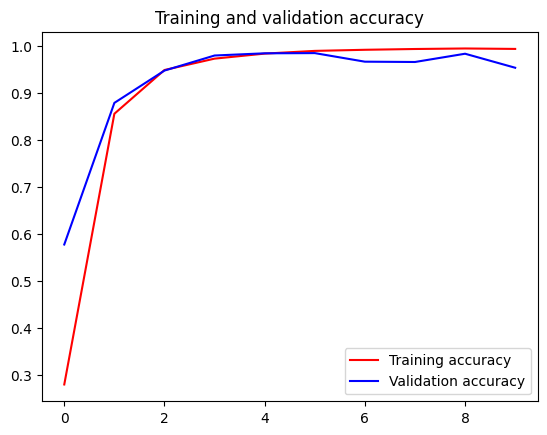

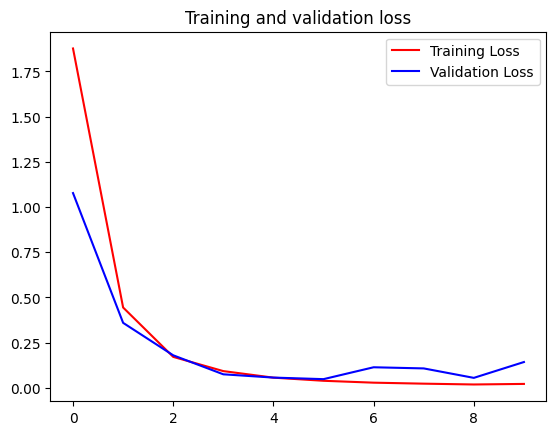

In [ ]:
import matplotlib.pyplot as plt

acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **TESTING THE MODELS**

# Predicting and Comparing the results between the two models

In [ ]:
from tensorflow.keras.models import load_model

model1 = load_model('model5with500k.h5')
model2 = load_model('modelbnwith500k.h5')


In [ ]:
#Loading the test images in a csv file

import os
import csv

test_dir = 'state-farm-distracted-driver-detection/imgs/test'
csv_file = 'test_labels.csv'  # Output CSV file for test images

# Open the CSV file for writing
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image_path'])  # Only one column for image paths

    # Walk through the directory structure
    for root, dirs, files in os.walk(test_dir):
        for name in files:
            if name.lower().endswith(".jpg"):
                image_path = os.path.join(root, name)  # Full path to image
                writer.writerow([image_path])  # Write to CSV

print("CSV file creation for test images is complete.")


CSV file creation for test images is complete.


In [ ]:
import pandas as pd

# Load CSV to check paths
csv_file = 'test_labels.csv'
data = pd.read_csv(csv_file)

# Print the first few rows of the dataframe
print(data.head(1))


                                          image_path
0  state-farm-distracted-driver-detection/imgs/te...


Creating test Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
import pandas as pd

# Load the CSV file into a DataFrame
test_df = pd.read_csv('test_labels.csv')

# Create the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,  # None since the paths in the CSV file are absolute
    x_col='image_path',
    y_col=None,  # None since we don't have labels
    target_size=(224, 224),
    class_mode=None,  # None because we don't have labels
    batch_size=32,
    shuffle=False  # Don't shuffle to maintain the order
)

Found 79726 validated image filenames.


Predictions

In [ ]:
predictions1 = model1.predict(test_generator)
predictions2 = model2.predict(test_generator)

/home/exouser/.conda/envs/a4/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2492/2492 ━━━━━━━━━━━━━━━━━━━━ 233s 93ms/step
2492/2492 ━━━━━━━━━━━━━━━━━━━━ 217s 87ms/step


Saving the predictions in a csv file

In [ ]:

predicted_classes1 = predictions1.argmax(axis=1)
predicted_classes2= predictions2.argmax(axis=1)

# Add the predicted classes to the DataFrame
test_df['predicted_class'] = predicted_classes1
test_df['predicted_class_with_BN'] = predicted_classes2

# Save the DataFrame back to CSV, with predictions
test_df.to_csv('test_with_predictions.csv', index=False)


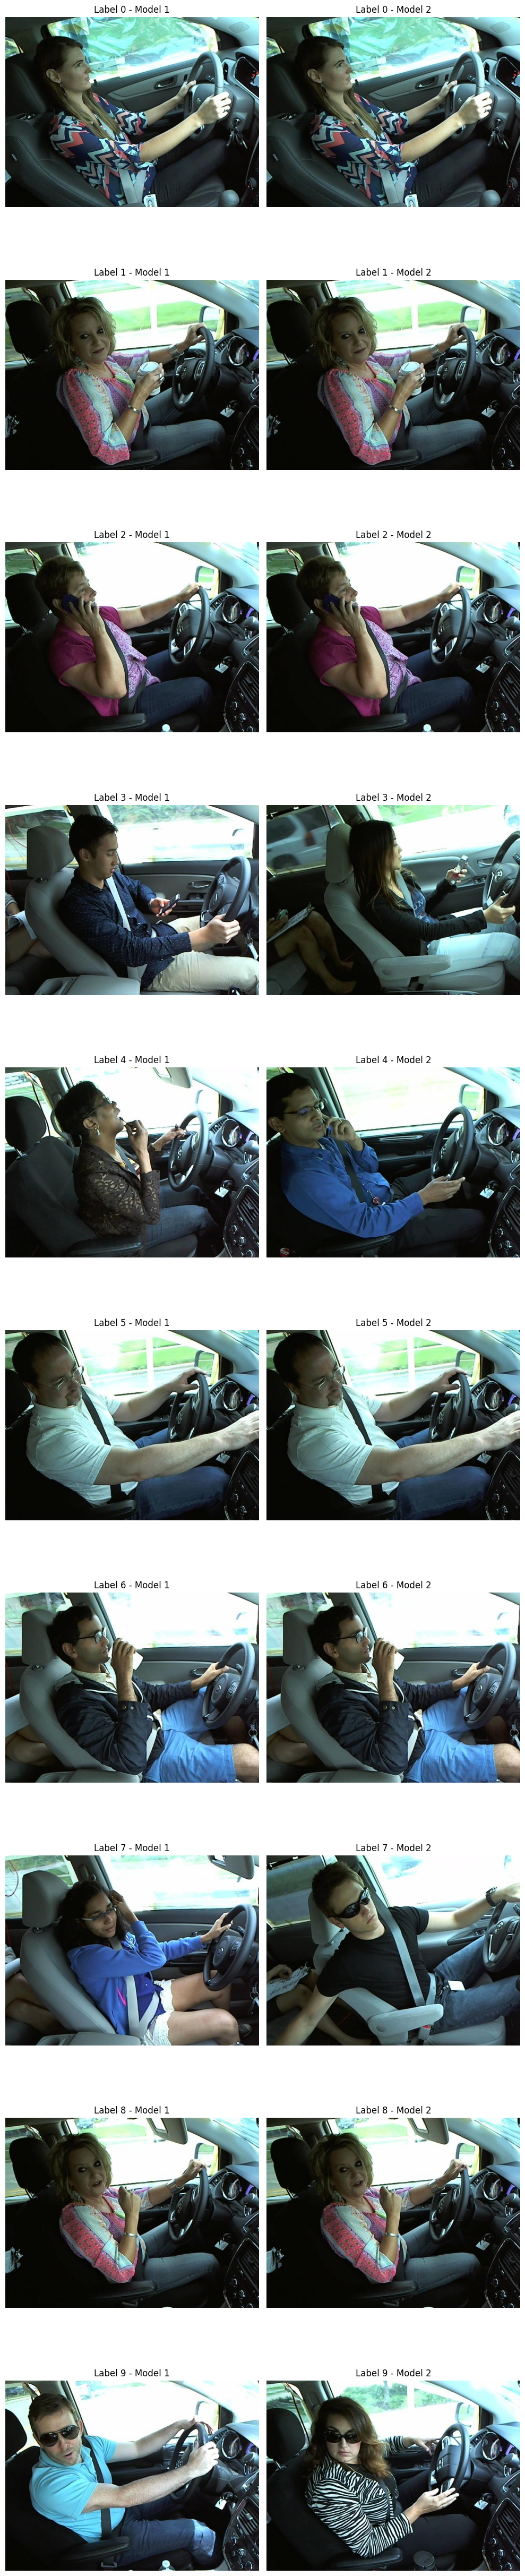

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the predictions CSV file
predictions_csv_path = 'test_with_predictions.csv'
predictions_df = pd.read_csv(predictions_csv_path)

# =get unique labels from both models
unique_labels = set(predictions_df['predicted_class']).union(set(predictions_df['predicted_class_with_BN']))

# To store image paths for each label
image_paths_per_label_model1 = {}
image_paths_per_label_model2 = {}

# Loop over the dataframe and collect one image path per label for each model
for label in unique_labels:
    for _, row in predictions_df.iterrows():
        if row['predicted_class'] == label and label not in image_paths_per_label_model1:
            image_paths_per_label_model1[label] = row['image_path']
        if row['predicted_class_with_BN'] == label and label not in image_paths_per_label_model2:
            image_paths_per_label_model2[label] = row['image_path']


base_img_path = os.path.dirname(predictions_csv_path)

# Plot the images side by side
fig, axs = plt.subplots(len(unique_labels), 2, figsize=(10, 50))  # Adjust figsize as needed

for i, label in enumerate(sorted(unique_labels)):
    # Load the image for the first model
    img_path1 = os.path.join(base_img_path, image_paths_per_label_model1[label])
    img1 = Image.open(img_path1)
    axs[i, 0].imshow(img1)
    axs[i, 0].set_title(f"Label {label} - Model 1")
    axs[i, 0].axis('off')

    # Load the image for the second model
    img_path2 = os.path.join(base_img_path, image_paths_per_label_model2[label])
    img2 = Image.open(img_path2)
    axs[i, 1].imshow(img2)
    axs[i, 1].set_title(f"Label {label} - Model 2")
    axs[i, 1].axis('off')

plt.tight_layout()


output_file_path = 'comparison_figure_500k.png'

# Save the figure
plt.savefig(output_file_path)
plt.show()
